In [21]:
from IPython.display import HTML
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn.metrics
import sklearn.metrics.pairwise
import csv
import os
import glob
import gc
import imageio
from skimage.io import imread 
from skimage.transform import resize
from tqdm import tqdm
import torch
from torch import nn
from torch.autograd import Variable
import statistics 
# import tensorflow as tf

plt.rc('figure', max_open_warning = 0) #To get rid of the max_open_warning output (Pink warning when plotting the Recurrence Plots)

# Content
1. [Automatical data processing for every recorded mission](#Automatical)
2. [Convolutional Autoencoder](#Autoencoder) 

### Functions concerning the data manipulation:

In [ ]:
def recurrence_plot(s, eps=None, steps=None):
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = sklearn.metrics.pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    return d

def load_csv(csv_filename, resample_period):   
    """ 
    Use a epoch timestamp as datetime index for a dataframe        
    This function read from a epoch column the datetime and uses it as index for the dataframe    
    """    
    if not Path(csv_filename).exists():
        print('WARNING! The file', csv_filename, 'could not be found!')
        return None
    df = pd.read_csv(csv_filename)
    df['date'] = pd.to_datetime(df['field.header.stamp'], unit='ns')    
    df = df.set_index('date')    
    df = df.resample(resample_period).mean()
    return df

def normalization(df_x, max_x, min_x, signal_name):
        """
        Returns the normalized df of the inputted df. Normalization is performed based on the inputted max & min of the df.  
        Default range is [0, 1]. Therefore, anything above 1 will equal 1, whilst everything below 0 will equal 0.
        """
        x = df_x.values
        
        x_scaled = (x - min_x)/(max_x - min_x)
        
        num_rows, num_clmn = x_scaled.shape
        for i in range(0, num_rows):
            if x_scaled[i] > 1:
                x_scaled[i] = 1
            if x_scaled[i] < 0:
                x_scaled[i] = 0

        norm_df_x = pd.DataFrame(x_scaled) 
        norm_df_x.columns = [signal_name]
        
        return norm_df_x

def data_slicing(df_x, n, k):
        """
        Returns the sliced ls of the inputted df, where n = size of windows in seconds and k = size of step in seconds
        These variables are usually chosen to be respectively 30sec & 10sec.
        The shape of the returning list will be 3D. 
        """
        num_rows, num_cols = df_x.shape
        sliced_ls_x = np.array([df_x[i:i+n].values.tolist() for i in range(0,num_rows-n,k)] ,  dtype=np.float64) 
        return sliced_ls_x

### Functions concerning data conversion:

In [ ]:
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians
    
def convert_quaternion_to_rpy(df):
    xs = df["field.orientation.x"].tolist()
    ys = df["field.orientation.y"].tolist()
    zs = df["field.orientation.z"].tolist()
    ws = df["field.orientation.w"].tolist()
    
    roll = []
    pitch = []
    yaw = []
    
    for x, y, z, w in zip(xs, ys, zs, ws):
        r, p, h = euler_from_quaternion(x, y, z, w)
        roll.append(r)
        pitch.append(p)
        yaw.append(h)   
    
    df['roll'] = roll
    df['pitch'] = pitch
    df['yaw'] = yaw
    return df
        

def depth_from_pressure(pressure):
        """
        Convert a pressure reading to depth in metres. 
        Assuming a constant seawater density of 1025kg/m^3.
        """
        depth = (pressure)/(1025 * 9.81) # Where ρ = 1026kg/m3 and g = 9.81m/s
        return depth  # in meters

### Function concerning folders' house keeping:

In [ ]:
from pathlib import Path
def emptying_subfolders(folders):
    for folder in folders:
        folder = Path(folder)
        if not folder.exists():
            folder.mkdir(parents=True)
        filelist = [f for f in os.listdir(folder)]
        folder_dir = ['{0}/{1}/*'.format(folder, filelist[i+1]) for i in range(0, len(filelist)-1)]
        for i in range (0, len(folder_dir)):
            files = glob.glob(folder_dir[i])
            for f in files:
                os.remove(f) 

# 1. Automatical data processing for every mission <a name="Automatical"></a>
Aim is to create one block of code, which would be able to read automatically all CSVs of all missions (flawless & flawed) and reproduce the Recurrence Plots for a period of time of 30seconds. 

NOTE: Only input that might be reuqired is the number of missions present under the Data folder, as well as the change of directory between flawless & flawed missions.

### 1.1 Addressing the total number of simulations for flawless and flawed missions

In [ ]:
num_sim_flawless = 6

In [ ]:
num_sim_flawed = 4

### 1.2 Addressing all variables within lists

In [ ]:
# NB: ALTITUDE SIGNAL ON MISSION 1 HAS WRONG DATA STAMP SO WE WILL NEED TO RE-RECORD THAT FIRST MISSION. 
# HENCE, FOR LOOP IS STARTING FROM 2. ADJUST THAT WHEN MISSION 1 IS RE-RECORDED. 

signal_type = ["altitude", "dvl", "imu", "navpressure", "thruster_setpoints"]
signal_name = ["altitude", "dvl_x", "dvl_y", "dvl_z", "roll_x", "pitch_y", "yaw_z", "depth", "t_sp_0", "t_sp_1", "t_sp_2"]


msg_type = ["field.range", "field.velocity.x", "field.velocity.y", "field.velocity.z", "field.orientation.x", "field.orientation.y", "field.orientation.z", "field.orientation.w", "field.fluid_pressure", "field.setpoints0", "field.setpoints1", "field.setpoints2"]
#Message Types will be used to read the column of interest from the dfs for the many operations.
conv_msg_type = ["roll_x", "pitch_y", "yaw_z", "depth"] 

init_df_holder = ["df_imu_x", "df_imu_y", "df_imu_z", "df_imu_w", "df_pressure"] 
init_ls_holder = ["ls_imu_x", "ls_imu_y", "ls_imu_z", "ls_imu_w", "ls_pressure"]

ls_holder = ["ls_alt", "ls_dvl_x", "ls_dvl_y", "ls_dvl_z", "ls_roll_x", "ls_pitch_y", "ls_yaw_z", "ls_depth", "ls_tsp_0", "ls_tsp_1", "ls_tsp_2"]
df_holder = ["df_alt", "df_dvl_x", "df_dvl_y", "df_dvl_z", "df_roll_x", "df_pitch_y", "df_yaw_z", "df_depth", "df_tsp_0", "df_tsp_1", "df_tsp_2"]

DM_ls_holder = ["DM_ls_alt", "DM_ls_dvl_x", "DM_ls_dvl_y", "DM_ls_dvl_z", "DM_ls_roll_x", "DM_ls_pitch_y", "DM_ls_yaw_z", "DM_ls_depth", "DM_ls_tsp_0", "DM_ls_tsp_1", "DM_ls_tsp_2"]
DM_df_holder = ["DM_df_alt", "DM_df_dvl_x", "DM_df_dvl_y", "DM_df_dvl_z", "DM_df_roll_x", "DM_df_pitch_y", "DM_df_yaw_z", "DM_df_depth", "DM_df_tsp_0", "DM_df_tsp_1", "DM_df_tsp_2"]

max_holder = [15, 1.5, 4.42E-01, 0.5, math.pi, math.pi, math.pi, 15, 1, 1, 1]
min_holder = [1, -1.5, -8.23E-02, -0.5, -math.pi, -math.pi, -math.pi, 0, -1, -1, -1]
# Sequence of above maxima & minima follow the alphabetical order of the signals (i.e. as in signal_type list).

mission_lyrs_flawless = []
mission_lyrs_flawed = []

### 1.3 Emptying folders from previous data gatherings

In [ ]:
folders = ['Time Plots', 'Recurrence Plots', 'Distance Matrices','Concatenated Recurrence Plots', 'Concatenated Distance Matrices']
emptying_subfolders(folders)

### 1.4 Automatic creation of Recurrence Plots for Flawless Missions 
NOTE: Usually errors appear due to unchanged time stamp on CSVs

In [ ]:
def scale(df_row, scaling_dict):
    df_row = (df_row - scaling_dict['min'])/(scaling_dict['max'] - scaling_dict['min'])
    df_row[df_row > 1] = 1
    df_row[df_row < 0] = 0
    return df_row
    
output_dict = {
    'altitude': [],
    'speed_x': [],
    'speed_y': [],
    'speed_z': [],
    'roll': [],
    'pitch': [],
    'yaw': [],
    'depth': [],
    'setpoint0': [],
    'setpoint1': [],
    'setpoint2': [],
}

scaling = {
    'altitude': { # m
        'min': 1.,
        'max': 60.,
    },
    'speed': { # m/s
        'min': -1.5,
        'max': 1.5,
    },
    'roll_pitch': { # rad
        'min': -math.pi/4,
        'max': math.pi/4,
    },
    'yaw': {  # rad
        'min': -math.pi,
        'max': math.pi,
    },
    'depth': { # m
        'min': 0.,
        'max': 60.,
    },
    'setpoints': { # rate
        'min': -1.,
        'max': 1.,
    },
}

In [ ]:
def create_input_data(basename, num_missions):
    for i in range(num_missions):
        print('Loading', basename, 'mission', i+1)
        # Load all CSVs
        df_altitude = load_csv(
            'Data/{0}_{1}_altitude.csv'.format(basename, i+1), 
            resample_period='1s')
        print('  Shape of df_altitude', df_altitude.shape)
        df_dvl = load_csv(
            'Data/{0}_{1}_dvl.csv'.format(basename, i+1), 
            resample_period='1s')
        print('  Shape of df_dvl', df_dvl.shape)
        df_imu = load_csv(
            'Data/{0}_{1}_imu.csv'.format(basename, i+1), 
            resample_period='1s')
        print('  Shape of df_imu', df_imu.shape)
        df_pressure = load_csv(
            'Data/{0}_{1}_navpressure.csv'.format(basename, i+1), 
            resample_period='1s')
        print('  Shape of df_pressure', df_pressure.shape)
        df_thruster_setpoints = load_csv(
            'Data/{0}_{1}_thruster_setpoints.csv'.format(basename, i+1), 
            resample_period='1s')
        print('  Shape of df_thruster_setpoints', df_thruster_setpoints.shape)
        
        if df_altitude is None or df_dvl is None or df_imu is None or df_pressure is None or df_thruster_setpoints is None:
            return

        # Keep common time samples
        merged_df = pd.merge(df_altitude, df_dvl, how='inner', left_index=True, right_index=True)
        merged_df = pd.merge(merged_df, df_imu, how='inner', left_index=True, right_index=True)
        merged_df = pd.merge(merged_df, df_pressure, how='inner', left_index=True, right_index=True)
        merged_df = pd.merge(merged_df, df_thruster_setpoints, how='inner', left_index=True, right_index=True)

        print('  Shape of merged df', merged_df.shape)
        common_entries, _ = merged_df.shape
        if common_entries == 0:
            print('WARNING! Mission', basename, i+1, 'seems to be corrupted.')

        # Convert quaternion to RPY 
        merged_df = convert_quaternion_to_rpy(merged_df)
        # Convert pressure (bars) to MSW
        merged_df['depth'] = depth_from_pressure(merged_df['field.fluid_pressure'])

        # Form the output dictionary and scale each value
        output_dict['altitude'] = scale(merged_df['field.range'], scaling['altitude'])
        output_dict['speed_x'] = scale(merged_df['field.velocity.x'], scaling['speed'])
        output_dict['speed_y'] = scale(merged_df['field.velocity.y'], scaling['speed'])
        output_dict['speed_z'] = scale(merged_df['field.velocity.z'], scaling['speed'])
        output_dict['roll'] = scale(merged_df['roll'], scaling['roll_pitch'])
        output_dict['pitch'] = scale(merged_df['pitch'], scaling['roll_pitch'])
        output_dict['yaw'] = scale(merged_df['yaw'], scaling['yaw'])
        output_dict['depth'] = scale(merged_df['depth'], scaling['depth'])
        output_dict['setpoint0'] = scale(merged_df['field.setpoints0'], scaling['setpoints'])
        output_dict['setpoint1'] = scale(merged_df['field.setpoints1'], scaling['setpoints'])
        output_dict['setpoint2'] = scale(merged_df['field.setpoints2'], scaling['setpoints'])

        # Convert to pandas DataFrame
        output_df = pd.DataFrame.from_dict(output_dict)
        output_df_filepath = Path('merged_and_normalised/{0}_{1}.csv'.format(basename, i))
        if not output_df_filepath.parent.exists():
            output_df_filepath.parent.mkdir(parents=True)
        output_df.to_csv(output_df_filepath)

        # Slice
        sliced_df = data_slicing(output_df, 30, 10)
        print('  Shape of sliced df', sliced_df.shape)

        # Skip further processing if this mission is corrupted.
        if len(sliced_df.shape) != 3:
            print('WARNING! Mission ', basename, i+1, 'seems to be corrupted.')
            continue

        # Show debug figure. All values must be between 0 and 1
        plt.figure()
        ax = output_df.plot();
        ax.set_title(basename + ' ' + str(i+1))
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

        # Create recurrence plots and save them to disk
        num_lyrs, num_rows, num_cols = sliced_df.shape    
        for j in range(num_lyrs): 
            sliced_array = sliced_df[j]
            combined = np.zeros((num_rows*num_cols, 1))
            for x in range(num_rows): # 30
                for y in range(num_cols): # 11
                    combined[y*num_rows + x] = sliced_array[x][y]
            DM_ls_combined = recurrence_plot(combined)
            DM_df_combined = pd.DataFrame(DM_ls_combined)
            output_csv_filepath = Path('Concatenated Distance Matrices/{0}_{1}/Con_DM_{1}_{2}.csv'.format(basename, i, j))
            if not output_csv_filepath.parent.exists():
                output_csv_filepath.parent.mkdir(parents=True)
            DM_df_combined.to_csv(output_csv_filepath)
            # uint8 images go to 255, current max values close to 10.
            # print(np.max(DM_df_combined.to_numpy()), np.min(DM_df_combined.to_numpy()))
            DM_array = DM_df_combined.to_numpy() * 20 
            DM_array = DM_array.astype(np.uint8)
            output_figure_filepath = Path('Concatenated Recurrence Plots/{0}_{1}/Con_RP_{1}_{2}.png'.format(basename, i, j))
            if not output_figure_filepath.parent.exists():
                output_figure_filepath.parent.mkdir(parents=True)
            imageio.imwrite(output_figure_filepath, DM_array)

        print("Data analysis for {0} mission {1} is completed.". format(basename, i))
    

In [ ]:
create_input_data('flawless', num_sim_flawless)

In [ ]:
create_input_data('flawed', num_sim_flawed) #NOTE: thruster_setpoints_noised is the topic on which one should subsribe on IQUAview. The topic's csv is renamed to thruster_setpoints

# 2. Convolutional Autoencoder <a name="Autoencoder"></a>
Let's select the images for training
Let's select the images for the test. Select one set of train data per flawed mission. Alter: (1) for range, (2) file path.

In [45]:
train_img = []
test_img = []

training_folders = [
    'Concatenated Recurrence Plots/flawless_0',
    'Concatenated Recurrence Plots/flawless_1',
    'Concatenated Recurrence Plots/flawless_2',
    'Concatenated Recurrence Plots/flawless_3',
    'Concatenated Recurrence Plots/flawless_4',
    'Concatenated Recurrence Plots/flawless_5',
]

# IDEALY you want to use a different dive to test! I am using the same to test the code
testing_folders = [
#     'Concatenated Recurrence Plots/flawed_0',
#     'Concatenated Recurrence Plots/flawed_1', 
#     'Concatenated Recurrence Plots/flawed_2', 
    'Concatenated Recurrence Plots/flawless_2',
]

for folder in training_folders:
    for item in glob.glob(folder + '/*.png'):
        # reading the image
        img = imread(item, as_gray=True) # initially 1080x1080 
        img = resize(img, (216, 224))
        # converting the type of pixel to float 32
        img = img.astype('float32')
        # normalizing the pixel values
        img /= 255.0
        # appending the image into the list
        train_img.append(img)
        
for folder in testing_folders:
    for item in glob.glob(folder + '/*.png'):
        # reading the image
        img = imread(item, as_gray=True) # initially 1080x1080 
        img = resize(img, (216, 224))
        # converting the type of pixel to float 32
        img = img.astype('float32')
        # normalizing the pixel values
        img /= 255.0
        # appending the image into the list
        test_img.append(img)
        
train_x = np.array(train_img)
test_x = np.array(test_img)

print('Train shape', train_x.shape)
print('Test shape', test_x.shape)

Train shape (975, 216, 224)
Test shape (209, 216, 224)


Sample images :

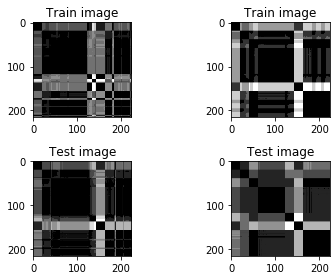

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(train_img[15], cmap='gray')
ax[0].set_title("Train image")

ax[1].imshow(train_img[100], cmap='gray')
ax[1].set_title("Train image")

ax[2].imshow(test_img[15], cmap='gray')
ax[2].set_title("Test image")

ax[3].imshow(test_img[100], cmap='gray')
ax[3].set_title("Test image")


plt.tight_layout()
plt.show()

In [47]:
# Creating tensors per mission.
train_x = train_x.reshape(train_x.shape[0], 1, 216, 224)
train_x = torch.from_numpy(np.asarray(train_x))
print(train_x.shape)

test_x = test_x.reshape(test_x.shape[0], 1, 216, 224)
test_x = torch.from_numpy(np.asarray(test_x))
print(test_x.shape)

torch.Size([975, 1, 216, 224])
torch.Size([209, 1, 216, 224])


**NOTE**: Skip folowing two boxes if needed!

**Let's define the convolutional auto-encoder in Pytorch**

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        #self.conv1 = nn.Conv2d(4, 16, 3, padding=1)  
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) #gray 
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        #self.t_conv2 = nn.ConvTranspose2d(16, 4, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)#gray


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

The measure that allows us to calculate the performance of the autocoder is the **mean square error**

In [48]:
import torch.utils.data

num_workers = 0
# how many samples per batch to load
batch_size = 64
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_x, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_x, batch_size=batch_size, num_workers=num_workers)

**NOTE**: Skip training if needed!

Let's run training on a number of Epochs

In [8]:
n_epochs = 1501

loss_by_epoch = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images = data.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
    
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    loss_by_epoch.append(train_loss)
    if(epoch % 10 == 1):
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))

C:\Users\ppkar\anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 13.450257
Epoch: 11 	Training Loss: 0.061306
Epoch: 21 	Training Loss: 0.009563
Epoch: 31 	Training Loss: 0.003933
Epoch: 41 	Training Loss: 0.002094
Epoch: 51 	Training Loss: 0.001268
Epoch: 61 	Training Loss: 0.000831
Epoch: 71 	Training Loss: 0.000573
Epoch: 81 	Training Loss: 0.000408
Epoch: 91 	Training Loss: 0.000295
Epoch: 101 	Training Loss: 0.000215
Epoch: 111 	Training Loss: 0.000155
Epoch: 121 	Training Loss: 0.000110
Epoch: 131 	Training Loss: 0.000079
Epoch: 141 	Training Loss: 0.000062
Epoch: 151 	Training Loss: 0.000051
Epoch: 161 	Training Loss: 0.000045
Epoch: 171 	Training Loss: 0.000040
Epoch: 181 	Training Loss: 0.000036
Epoch: 191 	Training Loss: 0.000034
Epoch: 201 	Training Loss: 0.000031
Epoch: 211 	Training Loss: 0.000030
Epoch: 221 	Training Loss: 0.000028
Epoch: 231 	Training Loss: 0.000027
Epoch: 241 	Training Loss: 0.000026
Epoch: 251 	Training Loss: 0.000025
Epoch: 261 	Training Loss: 0.000024
Epoch: 271 	Training Loss: 0.000023
Ep

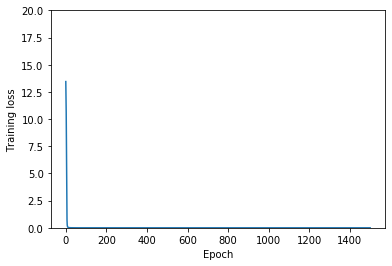

In [9]:
plt.figure()
plt.plot(loss_by_epoch)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.ylim([0,20])
plt.show()

Let's move on to the test part 

C:\Users\ppkar\anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


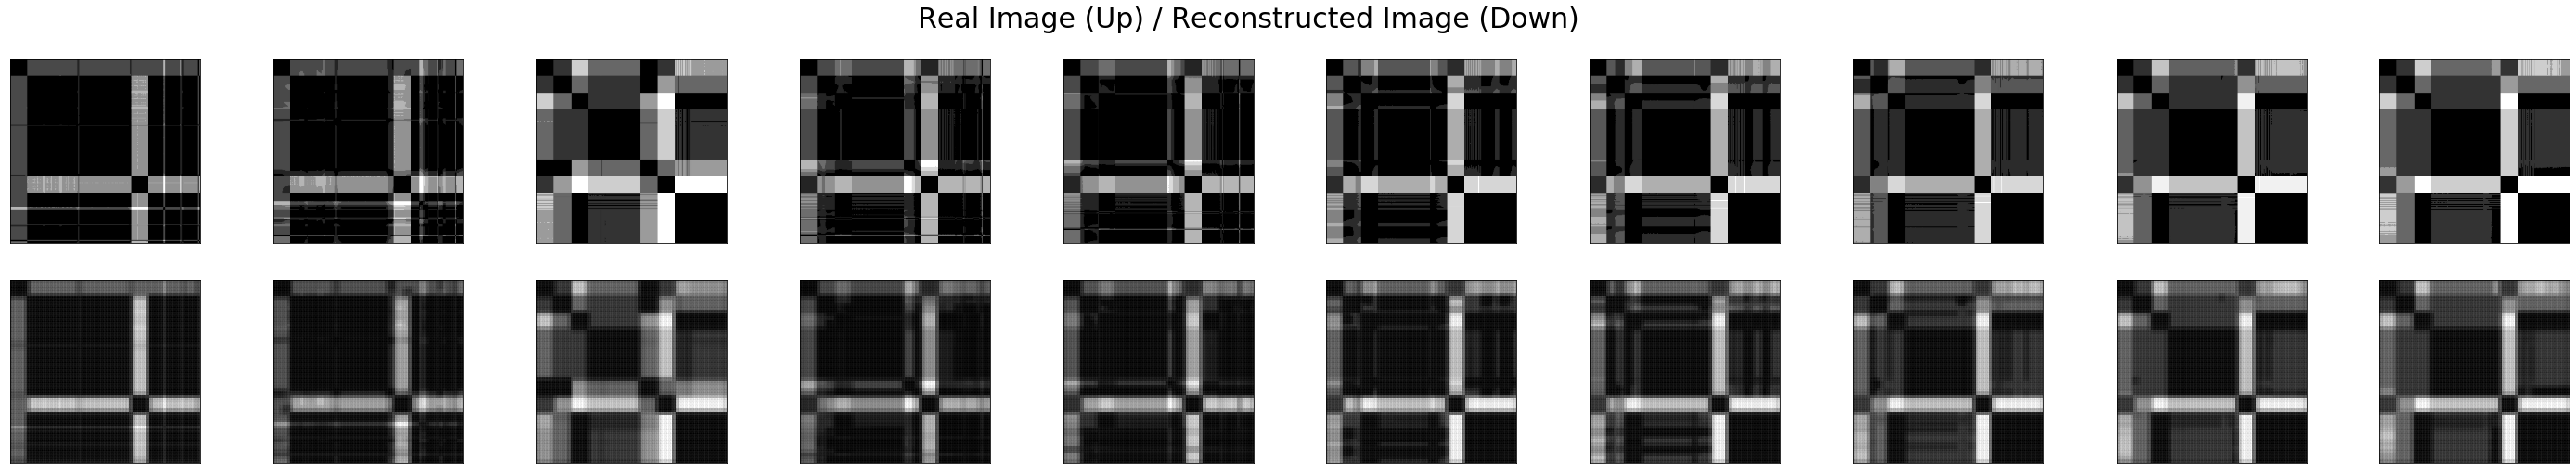

In [49]:
dataiter = iter(test_loader)
images= dataiter.next()
output = model(images.cuda())
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 216, 224)

# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()


fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(50,8))
fig.suptitle("Real Image (Up) / Reconstructed Image (Down)", fontsize=30)
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img[0]), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Let's visualize the reconstruction error on the test compared to the corresponding period

In [50]:
batch_size = 1 
test_loader = torch.utils.data.DataLoader(test_x, batch_size=batch_size, num_workers=num_workers)


losses = []
images_test = []

torch.cuda.empty_cache()

count = 0

print(len(test_loader))
print(test_loader)
print()

for data in test_loader:
    # _ stands in for labels, here
    # no need to flatten images
    images = data.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    outputs = model(images)
    # calculate the loss
    losses.append(criterion(outputs, images).item())
    print("losses:", losses)
    print("images.size(0):", images.size(0))
    images_test.append(images.view(images.size(0), 1*216*224).detach().cpu().numpy())
#     images_test.append(images.view(batch_size, 1, 216,224).detach().cpu().numpy())
    count = count + 1
    print("count:", count)
    print()
    
print(count)
print(statistics.mean(losses))


209

losses: [2.2955616429953807e-07]
images.size(0): 1
count: 1

losses: [2.2955616429953807e-07, 2.2526734255734482e-07]
images.size(0): 1
count: 2

losses: [2.2955616429953807e-07, 2.2526734255734482e-07, 1.78594376620822e-07]
images.size(0): 1
count: 3

losses: [2.2955616429953807e-07, 2.2526734255734482e-07, 1.78594376620822e-07, 2.486206085450249e-07]
images.size(0): 1
count: 4

losses: [2.2955616429953807e-07, 2.2526734255734482e-07, 1.78594376620822e-07, 2.486206085450249e-07, 2.456202707890043e-07]
images.size(0): 1
count: 5

losses: [2.2955616429953807e-07, 2.2526734255734482e-07, 1.78594376620822e-07, 2.486206085450249e-07, 2.456202707890043e-07, 2.391787461419881e-07]
images.size(0): 1
count: 6

losses: [2.2955616429953807e-07, 2.2526734255734482e-07, 1.78594376620822e-07, 2.486206085450249e-07, 2.456202707890043e-07, 2.391787461419881e-07, 2.1785739079405175e-07]
images.size(0): 1
count: 7

losses: [2.2955616429953807e-07, 2.2526734255734482e-07, 1.78594376620822e-07, 2.48

count: 41

losses: [2.2955616429953807e-07, 2.2526734255734482e-07, 1.78594376620822e-07, 2.486206085450249e-07, 2.456202707890043e-07, 2.391787461419881e-07, 2.1785739079405175e-07, 2.0049435534019722e-07, 1.9512468441007513e-07, 1.9666158834752423e-07, 1.9718295618531556e-07, 1.981923816174458e-07, 2.0604599626494746e-07, 1.788033046068449e-07, 2.223274719881374e-07, 2.364284767963909e-07, 2.4449360580547363e-07, 2.740808611179091e-07, 3.097957232967019e-07, 3.1732585625832144e-07, 2.898091793213098e-07, 2.7124858092975046e-07, 3.0598718581131834e-07, 3.1775746833773155e-07, 1.7871305146854866e-07, 3.1232428909788723e-07, 3.162335246997827e-07, 3.2410054018328083e-07, 3.0858305422043486e-07, 2.792833129205974e-07, 2.535990972774016e-07, 2.468771356234356e-07, 2.450012743793195e-07, 2.3179903507752897e-07, 2.1080857948163612e-07, 1.7791394668620342e-07, 1.9535033857209783e-07, 1.9588129873682192e-07, 1.9776656756675948e-07, 1.979029775611707e-07, 1.9993107969185075e-07, 2.115908444011

losses: [2.2955616429953807e-07, 2.2526734255734482e-07, 1.78594376620822e-07, 2.486206085450249e-07, 2.456202707890043e-07, 2.391787461419881e-07, 2.1785739079405175e-07, 2.0049435534019722e-07, 1.9512468441007513e-07, 1.9666158834752423e-07, 1.9718295618531556e-07, 1.981923816174458e-07, 2.0604599626494746e-07, 1.788033046068449e-07, 2.223274719881374e-07, 2.364284767963909e-07, 2.4449360580547363e-07, 2.740808611179091e-07, 3.097957232967019e-07, 3.1732585625832144e-07, 2.898091793213098e-07, 2.7124858092975046e-07, 3.0598718581131834e-07, 3.1775746833773155e-07, 1.7871305146854866e-07, 3.1232428909788723e-07, 3.162335246997827e-07, 3.2410054018328083e-07, 3.0858305422043486e-07, 2.792833129205974e-07, 2.535990972774016e-07, 2.468771356234356e-07, 2.450012743793195e-07, 2.3179903507752897e-07, 2.1080857948163612e-07, 1.7791394668620342e-07, 1.9535033857209783e-07, 1.9588129873682192e-07, 1.9776656756675948e-07, 1.979029775611707e-07, 1.9993107969185075e-07, 2.1159084440114384e-07, 2

losses: [2.2955616429953807e-07, 2.2526734255734482e-07, 1.78594376620822e-07, 2.486206085450249e-07, 2.456202707890043e-07, 2.391787461419881e-07, 2.1785739079405175e-07, 2.0049435534019722e-07, 1.9512468441007513e-07, 1.9666158834752423e-07, 1.9718295618531556e-07, 1.981923816174458e-07, 2.0604599626494746e-07, 1.788033046068449e-07, 2.223274719881374e-07, 2.364284767963909e-07, 2.4449360580547363e-07, 2.740808611179091e-07, 3.097957232967019e-07, 3.1732585625832144e-07, 2.898091793213098e-07, 2.7124858092975046e-07, 3.0598718581131834e-07, 3.1775746833773155e-07, 1.7871305146854866e-07, 3.1232428909788723e-07, 3.162335246997827e-07, 3.2410054018328083e-07, 3.0858305422043486e-07, 2.792833129205974e-07, 2.535990972774016e-07, 2.468771356234356e-07, 2.450012743793195e-07, 2.3179903507752897e-07, 2.1080857948163612e-07, 1.7791394668620342e-07, 1.9535033857209783e-07, 1.9588129873682192e-07, 1.9776656756675948e-07, 1.979029775611707e-07, 1.9993107969185075e-07, 2.1159084440114384e-07, 2

losses: [2.2955616429953807e-07, 2.2526734255734482e-07, 1.78594376620822e-07, 2.486206085450249e-07, 2.456202707890043e-07, 2.391787461419881e-07, 2.1785739079405175e-07, 2.0049435534019722e-07, 1.9512468441007513e-07, 1.9666158834752423e-07, 1.9718295618531556e-07, 1.981923816174458e-07, 2.0604599626494746e-07, 1.788033046068449e-07, 2.223274719881374e-07, 2.364284767963909e-07, 2.4449360580547363e-07, 2.740808611179091e-07, 3.097957232967019e-07, 3.1732585625832144e-07, 2.898091793213098e-07, 2.7124858092975046e-07, 3.0598718581131834e-07, 3.1775746833773155e-07, 1.7871305146854866e-07, 3.1232428909788723e-07, 3.162335246997827e-07, 3.2410054018328083e-07, 3.0858305422043486e-07, 2.792833129205974e-07, 2.535990972774016e-07, 2.468771356234356e-07, 2.450012743793195e-07, 2.3179903507752897e-07, 2.1080857948163612e-07, 1.7791394668620342e-07, 1.9535033857209783e-07, 1.9588129873682192e-07, 1.9776656756675948e-07, 1.979029775611707e-07, 1.9993107969185075e-07, 2.1159084440114384e-07, 2

losses: [2.2955616429953807e-07, 2.2526734255734482e-07, 1.78594376620822e-07, 2.486206085450249e-07, 2.456202707890043e-07, 2.391787461419881e-07, 2.1785739079405175e-07, 2.0049435534019722e-07, 1.9512468441007513e-07, 1.9666158834752423e-07, 1.9718295618531556e-07, 1.981923816174458e-07, 2.0604599626494746e-07, 1.788033046068449e-07, 2.223274719881374e-07, 2.364284767963909e-07, 2.4449360580547363e-07, 2.740808611179091e-07, 3.097957232967019e-07, 3.1732585625832144e-07, 2.898091793213098e-07, 2.7124858092975046e-07, 3.0598718581131834e-07, 3.1775746833773155e-07, 1.7871305146854866e-07, 3.1232428909788723e-07, 3.162335246997827e-07, 3.2410054018328083e-07, 3.0858305422043486e-07, 2.792833129205974e-07, 2.535990972774016e-07, 2.468771356234356e-07, 2.450012743793195e-07, 2.3179903507752897e-07, 2.1080857948163612e-07, 1.7791394668620342e-07, 1.9535033857209783e-07, 1.9588129873682192e-07, 1.9776656756675948e-07, 1.979029775611707e-07, 1.9993107969185075e-07, 2.1159084440114384e-07, 2

209
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840,

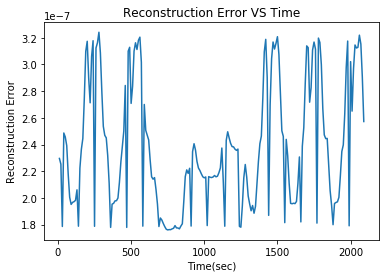

In [51]:
# Make x-axis in seconds, make sure it does not overlap. 30sec + 20sec + 20sec ...

x = []
num_slices = test_x.shape[0]
count = 0  
i = 1
print(num_slices)

for i in range(0, num_slices):
    count = count + 10
    x.append(count)
    i = i + 1
    
print(x)
print(len(x), "", len(losses))

# fig = plt.figure(figsize=(8,8))
# plt = fig.add_subplot(2, 1, 1)
plt.plot(x, losses)
plt.title("Reconstruction Error VS Time")
plt.xlabel("Time(sec)")
plt.ylabel("Reconstruction Error")
plt.show()

# plt.savefig('Loss Graphs/Flawed Mission 3 Loss Graph.png')
# ax = fig.add_subplot(2, 1, 2)
# ax.axis('off')
# ax.plot(df_holder[0])
# ax.set_title('Time-series')